# Find the most repeated words in game titles in different areas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
%matplotlib inline
warnings.filterwarnings("ignore")

# create a dataFrame object with title, score and release_year
data = pd.read_csv("ign.csv")[["title", "genre", "platform", "score_phrase", "score", "release_year"]]

games_by_year = data.sort('release_year')
games_by_year.head()

,title,genre,platform,score_phrase,score,release_year
516,The Walking Dead: The Game -- Episode 1: A New...,Adventure,Xbox 360,Great,8.5,1970
519,Gex,Platformer,PlayStation,Okay,6.0,1996
460,NBA In the Zone,Sports,PlayStation,Mediocre,5.0,1996
461,Magic Carpet,Action,PlayStation,Good,7.5,1996
462,Power Serve 3D Tennis,Sports,PlayStation,Painful,2.0,1996


Couple of functions to manipulate words.

In [2]:
# Counts the words in arr and returns a DataFrame which has a number of elements specified in see_how_many parameter
def item_counter(arr, see_how_many):
    item_dict = {}
    for item in arr:
        if item in item_dict:
            item_dict[item] += 1
        else:
            item_dict[item] = 1

    most_used = sorted(item_dict, key = item_dict.get, reverse=True)[:see_how_many]
    
    res = []
    for item in most_used:
        res.append((item, item_dict[item]))

    df = pd.DataFrame.from_records(res, columns=("name", "frequency"))
    df.sort("frequency")
    return df

In [3]:
import nltk
import re
from nltk.corpus import stopwords

# Gets rid of meaningless words, numbers, non-letter characters in order to obtain better results
## not_wanted (list) - A list of words to avoid
## game_names (pandas.DataFrame) - Game titles to iterate
def preprocess(not_wanted, game_names):
    words = []
    for name in game_names:
        words_in_name = nltk.word_tokenize(name)    # Split the game names by words and extend the words array
        for i in range(0, len(words_in_name)):
            re_form = re.sub(r'[^a-zA-Z ]', '', words_in_name[i]).split()    # The regular expression for words only, get rid of all non-letter characters
            if (len(re_form) > 0 and  not (re_form[0].lower() in not_wanted) ):
                words_in_name[i] = re_form[0].lower()    # As splitting names, lower the characters to help them be found in stopwords
                words.append(words_in_name[i])
                
    sw = stopwords.words("english")
    # Get rid of stopwords and numbers in words array to analyze better.
    for i in sw:
        while i in words:
            words.remove(i)
                
    return words

In [4]:
# Generates a bar graph from a given result DataFrame
def make_bar_graph(result, x_axis, y_axis):
    bar = result[[y_axis]].plot.barh(x=result[x_axis], legend=False, align="center", width=1.0, figsize=(10, 7), fontsize=12, color=np.random.rand(3,1))

A little bit more coding and finally, a list of most repeated words in game titles in the whole dataset.

In [5]:
# Unsignificant words, roman numerals and abbreviations to throw up, otherwise they can be seen in most common words many times.
DISTRACTIONS = ["i", "ii", "iii", "iv", "v", "vi", "vii", "fifa", "nba", "nfl", "vs", "k", "one", "two", "three", "four", "pga", "nhl", "ncaa"]

# Shows the word frequency of game titles with a bar graph
## make_graph (boolean) - Generates a bar graph if true, otherwise prints the standart pandas representation
## how_many (number) - Number of game instances to show
# TODO: words preprocessing can be inside of the item_counter
def see_every_game_name(make_graph, how_many):
    spec = data["title"]
    # print "Checking", len(spec), "games."

    words = preprocess(DISTRACTIONS, spec)
    result = item_counter(words, how_many)
    if make_graph:
        make_bar_graph(result, 'name', 'frequency')
    else:
        return result

In [6]:
# see_every_game_name(True, 20)

In [7]:
# Shows the word frequency of game titles with a bar graph using a score limit
## min_score (number) - Game names with scores >= min_score will be considered
## make_graph (boolean) - Generates a bar graph if true, otherwise prints the standart pandas representation
## how_many (number) - Number of game instances to show
def see_game_names_with_score_limit(min_score, make_graph, how_many):
    spec = data.loc[data["score"] >= min_score]["title"]
    
    # print "Checking", len(spec), "games."

    words = preprocess(DISTRACTIONS, spec)
    result = item_counter(words, how_many)
    if make_graph:
        make_bar_graph(result, 'name', 'frequency')
    else:
        return result

In [8]:
see_game_names_with_score_limit(8.0, False, 10)

,name,frequency
0,edition,240
1,dead,117
2,world,116
3,game,113
4,episode,109
5,super,108
6,wars,103
7,star,101
8,soccer,96
9,pro,89


In [9]:
# Shows the word frequency of game titles with a bar graph using a classificiation (release_year, score_phrase etc) and a key (1996, "Amazing" etc.)
## column_value_tuples [tuple] - A list of tuples as (column_name, value_name) for querying the data
## make_graph (boolean) - Generates a bar graph if true, otherwise prints the standart pandas representation
## how_many (number) - Number of game instances to show
def see_game_names_with_key(column_value_tuples, make_graph, how_many):
    spec = data
    for i in column_value_tuples:
        column = i[0]
        value = i[1]
        spec = spec.loc[spec[column] == value]
        
    # print "Checking", len(spec), "games."
    
    words = preprocess(DISTRACTIONS, spec["title"])

    result = item_counter(words, how_many)
    if make_graph:
        make_bar_graph(result, 'name', 'frequency')
    else:
        return result

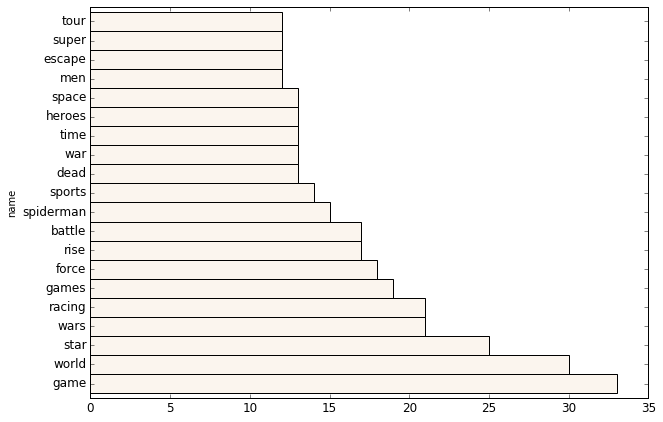

In [10]:
see_game_names_with_key([("score_phrase", "Bad")], True, 20)

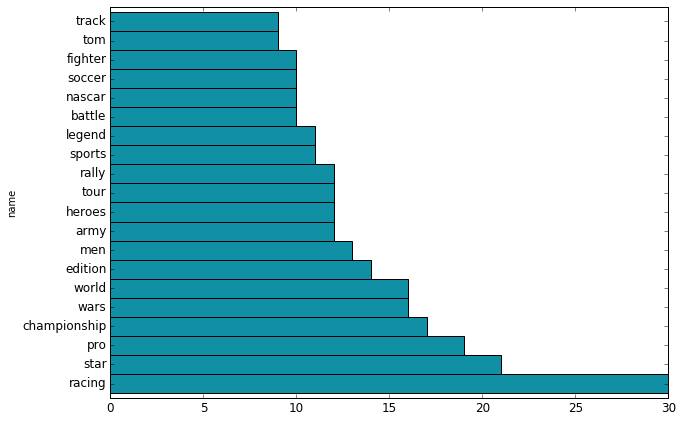

In [11]:
see_game_names_with_key([("release_year", 2000)], True, 20)

Let's see some **Amazing** games in **Sports**.

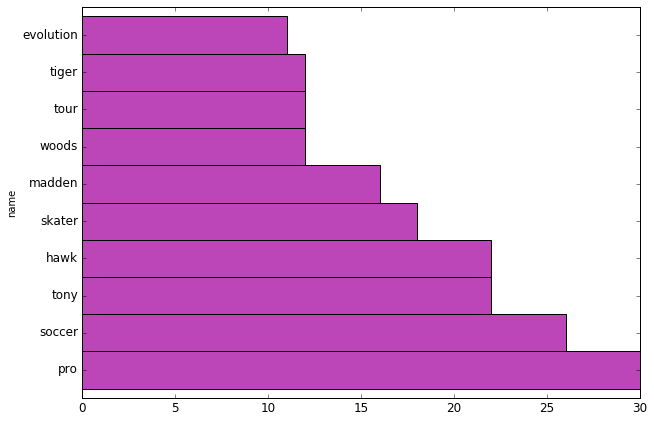

In [12]:
see_game_names_with_key([("genre", "Sports"), ("score_phrase", "Amazing")], True, 10)

In order to make things more interesting let's use a function to determine occurences of a word in different categories.

In [13]:
# Looks for occurence times of words in the given_words array in a column type specified by the user.
# given_words (list) - The list of words to search
# column_value_tuples [tuple] - An array of tuples that in form (column-name, column-value-to-match)
def word_occurences(given_words, column_value_tuples):
    spec = data
    for i in column_value_tuples:
        column = i[0]
        value = i[1]
        spec = spec.loc[spec[column] == value]
        
    # print "Checking", len(spec), "games."
    
    words = preprocess(DISTRACTIONS, spec["title"])
    occurences = {}
    for word in given_words:
        occurence = words.count(word)
        occurences[word] = occurence
    
    return occurences

Are there any masterpieces with word "theft" except GTA games?

In [14]:
word_occurences(["grand", "theft", "auto"], [("score_phrase", "Masterpiece")])

{'auto': 9, 'grand': 9, 'theft': 9}

Apparently not. Or better, we can see which score phrase has most of this word with the following function.

In [15]:
import operator

# Looks for every element in words in every column type of column, and gives the best repeated results in an array of objects.
# words (list) - An array of words to search for
# desired_column (string) - In which column type you want to search in
# how_many (number) - How many of them will be returned
def where_can_i_find_the_most(words, desired_column, how_many):
    dict_for_most = {}
    properties = data[desired_column].unique()
    
    for column_type in properties:
            dict_for_most[column_type] = word_occurences(words, [(desired_column, column_type)])
    result_arr = []

    slist = sorted(dict_for_most.items(), key=operator.itemgetter(1), reverse=True)
    return slist[:how_many]

And check for the dead platforms.

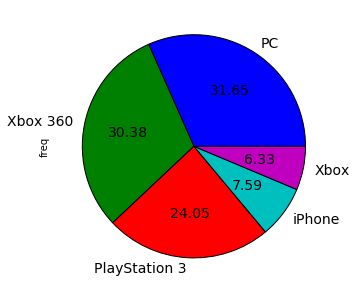

In [18]:
t = where_can_i_find_the_most(["dead"], "platform", 5)
for i in range(0,len(t)):
    t[i] = (t[i][0], t[i][1].values()[0])
where = pd.DataFrame.from_records(t, columns=("platform", "freq"))
where.plot.pie(y="freq", labels=where["platform"], autopct='%.2f', figsize=(5,5),legend=False, fontsize=14)

What if we can see how many games does a genre have with its own name in it? For instance "JoJo's Bizarre Adventure HD" has Adventure -its genre- in its name.

In [17]:
# game names with their genres' name in it
genre_types = data["genre"].unique()
genre_war_counts = []
for genre_name in genre_types:
    if type(genre_name) is float:
        continue
    count = word_occurences([genre_name.lower()],[("genre", genre_name)])
    genre_war_counts.append((genre_name, count.values()[0]))
genre_war_counts = sorted(genre_war_counts, key=lambda x : x[1], reverse=True)
genre_war_data = pd.DataFrame.from_records(genre_war_counts, columns=("genre_name", "frequency"))
genre_war_data[:10]

,genre_name,frequency
0,Racing,175
1,Sports,73
2,Pinball,61
3,Puzzle,56
4,Party,46
5,Adventure,27
6,Wrestling,23
7,Casino,15
8,Fighting,14
9,Action,10


So racing is the most self-explanatory genre by far.